# Minimal example to get EDR SHARAD data in numpy format
This is a minimal example to show how we can obtain the radargram and the topography of the acquisition from an EDR SHARAD file.
We convert both in .npy arrays.

Notice that we could extract more information from the .dat file, but we stick to the topography only for this minimal example.

When operating with this file, your folder should look like this:

    folder
        e_0814901_001_ss19_700_a_s.dat
        e_0814901_001_ss19_700_a.lbl.txt
        science_ancillary.fmt.txt

Where in this case I obtained the files from [Here](https://ode.rsl.wustl.edu/mars/indexproductpage.aspx?product_id=E_0814901_001_SS19_700_A&product_idGeo=26442095).

For this minimal example, we will obtain the radargram and the topography of the acquisition from the .dat file.
We obtain the number of records from the .lbl file. Here we simply read it and copy the value in the notebook but it is trivial to create a script to




In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Put here your file name obtained from MRO SHARAD PDS3 Experiment Data Record (EDR) (Raw Data)
fn = '/Users/jordy/Data/SHARAD/northern_flow/raw/e_4789001_001_ss19_700_a_s.dat'
fn_lbl = '/Users/jordy/Data/SHARAD/northern_flow/raw/e_4789001_001_ss19_700_a.lbl.txt'

In [3]:
# Extract the number of records from the lbl file
with open(fn_lbl, "r", encoding="utf-8") as f:
    rb_found = False # Only the first RECORD_BYTES line is related to our .dat, the other is for ancillary data
    for line in f:
        line = line.strip()  # remove leading/trailing whitespace
        if line.startswith("RECORD_BYTES") and rb_found is False:
            parts = line.split('=')
            if len(parts) == 2:
                RECORDBYTES = int(parts[1].strip())
                rb_found = True
        if line.startswith("FILE_RECORDS"):
            parts = line.split('=')
            if len(parts) == 2:
                NRECORDS = int(parts[1].strip())

if RECORDBYTES is not None:
    print("RECORD_BYTES =", RECORDBYTES)
else:
    print("RECORD_BYTES not found.")

if NRECORDS is not None:
    print("FILE_RECORDS =", NRECORDS)
else:
    print("FILE_RECORDS not found.")

RECORD_BYTES = 3786
FILE_RECORDS = 14746


In [4]:
ITEMS = 3600 # As per SHARAD docs, each record contains 3600 8bits MSB integers representing a rangeline.
OFFSET = 186 # As per SHARAD docs, the first 186 bytes of each record are ancillary headers.

A = np.zeros((RECORDBYTES,NRECORDS))
for i in range(NRECORDS):
    with open(fn, 'rb') as fid:
        A[:,i] = np.fromfile(fid, dtype='>i1', count=RECORDBYTES, offset= RECORDBYTES*i)
A = A[OFFSET:,:]
print(fn, A.shape)

raw_data = A.astype(np.int8)
np.save('raw_data.npy', raw_data)


/Users/jordy/Data/SHARAD/northern_flow/raw/e_4789001_001_ss19_700_a_s.dat (3600, 14746)


/var/folders/mb/0w20lnl16y5fksslt2bgf0tr0000gn/T/ipykernel_54117/1276005995.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  topo[i] = np.fromfile(fid, dtype='>f4', count=1, offset= OFFSET + RECORDBYTES*i)


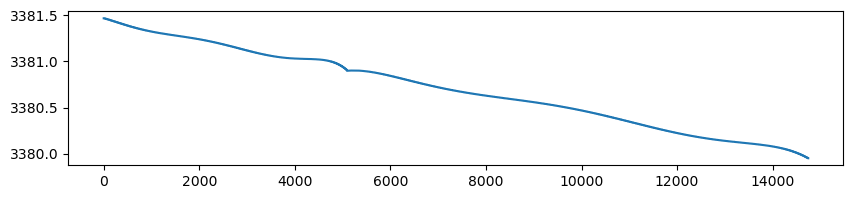

In [15]:
# Extract topography

# As per SHARAD docs, topography is saved as a 4bytes flotaing point value.
OFFSET = 170 # As per SHARAD docs, the topography is at position 170 in the record.

topo = np.zeros(NRECORDS)
for i in range(NRECORDS):
    with open(fn, 'rb') as fid:
        topo[i] = np.fromfile(fid, dtype='>f4', count=1, offset= OFFSET + RECORDBYTES*i)

plt.figure(figsize=(10, 2))
plt.plot(topo)

# Save topography [km]
np.save('topo.npy', topo.flatten())
